In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import oyster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-3500, xhi=2500, ylo=-2000, yhi=2500)

In [3]:
# Place an Argus I array on the retina
argus = e2cm.ArgusII(x_center=-500, y_center=200, h=100, rot=0*np.pi/180)

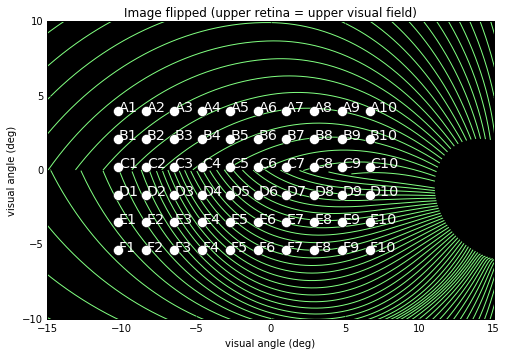

In [4]:
# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Plot location of implant on top of axon bundles
for e in argus.electrodes:
    ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5), e.name,
            color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))
ax.set_aspect('equal')
ax.set_xlim(-15, 15)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-10, 10)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')
fig.savefig('jansonius_argusI.eps')

In [5]:
retina.gridx

array([[-3500., -3400., -3300., ...,  2300.,  2400.,  2500.],
       [-3500., -3400., -3300., ...,  2300.,  2400.,  2500.],
       [-3500., -3400., -3300., ...,  2300.,  2400.,  2500.],
       ..., 
       [-3500., -3400., -3300., ...,  2300.,  2400.,  2500.],
       [-3500., -3400., -3300., ...,  2300.,  2400.,  2500.],
       [-3500., -3400., -3300., ...,  2300.,  2400.,  2500.]])

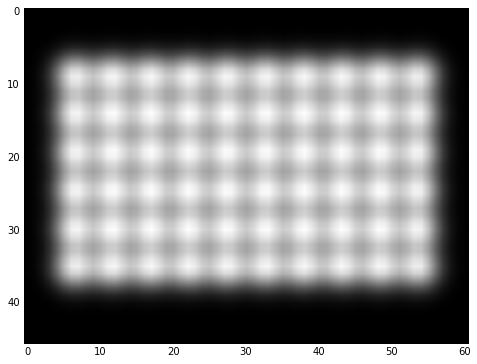

In [6]:
rfs = np.zeros_like(retina.gridx)
for e in argus:
    rfs += e2cm.receptive_field(e, retina.gridx, retina.gridy, 'gaussian')
plt.figure(figsize=(18, 6))
plt.imshow(rfs, cmap='gray')

In [7]:
# The temporal model contains the cascade of operations that leads from pulse to percept:
tsample = 0.005 / 1000  # Sample step (s)
tm = ec2b.TemporalModel(tsample)

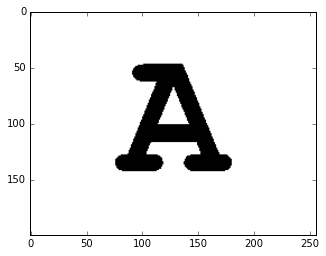

In [8]:
from skimage.io import imread
img = imread("letters/A.jpg", as_grey=True)
plt.imshow(img, cmap='gray')

In [9]:
# Requires scikit-image
stim = e2cm.image2pulsetrain(img, argus, coding='frequency', rftype='gaussian', invert=True, dur=0.1)

In [10]:
percept = ec2b.pulse2percept(stim, argus, tm, retina, n_jobs=8, dojit=True, tol=0.05)

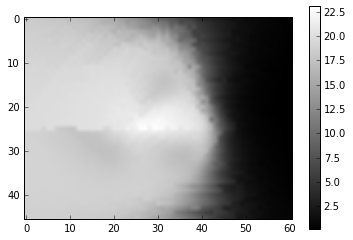

In [12]:
frame = ec2b.get_brightest_frame(percept)
plt.imshow(np.flipud(frame.data), cmap='gray')
plt.colorbar()